In [34]:
# write all import and warning statements here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_excel('../data/data_final.xlsx', index_col=0)

In [36]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [37]:
df.columns = df.columns.str.strip()

In [38]:
X = df.drop('Chance of Admit', axis=1)
y = df[["Chance of Admit"]]

In [39]:
X

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0
...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1
496,337,117,5,5.0,5.0,9.87,1
497,330,120,5,4.5,5.0,9.56,1
498,312,103,4,4.0,5.0,8.43,0


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)    
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)  

In [42]:
# store scaler in pickle file
import pickle
pickle.dump(scaler, open('../models/scaler.pkl', 'wb'))

In [43]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

In [66]:
# store model in pickle file
import pickle
pickle.dump(lr, open('../models/model_lr.pkl', 'wb'))

In [44]:
# score for train and test data

print(lr.score(x_train, y_train))

print(lr.score(x_test, y_test))

0.8210671369321554
0.8188432567829628


In [45]:
# r2 score and adjusted r2 score

from sklearn.metrics import r2_score, mean_squared_error

print(r2_score(y_test, y_pred))

print(1 - (1-r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))

0.8188432567829628
0.8050595915381882


In [46]:
lr.coef_

array([[0.02667052, 0.01822633, 0.00293995, 0.001788  , 0.0158655 ,
        0.06758106, 0.01194049]])

In [47]:
lr.coef_.flatten()

array([0.02667052, 0.01822633, 0.00293995, 0.001788  , 0.0158655 ,
       0.06758106, 0.01194049])

In [48]:
# put into a dataframe and sort by coefficients
pd.DataFrame(data=lr.coef_.flatten(), index=x_train.columns, columns=['Coefficients']).sort_values(by='Coefficients', ascending=False)

,Coefficients
CGPA,0.067581
GRE Score,0.026671
TOEFL Score,0.018226
LOR,0.015866
Research,0.011940
University Rating,0.002940
SOP,0.001788


In [49]:
import statsmodels.api as sm

In [50]:
y_train = pd.Series(y_train.values.flatten())

In [51]:
# y_train

In [52]:
X_sm = sm.add_constant(x_train) 

In [53]:
sm_model = sm.OLS(y_train, X_sm).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     257.0
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          3.41e-142
Time:                        20:54:19   Log-Likelihood:                 561.91
No. Observations:                 400   AIC:                            -1108.
Df Residuals:                     392   BIC:                            -1076.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7242      0.00

In [33]:
# University rating and sop have high p-value indicating they are insignificant

# we can remove them from our model

x_train = x_train.drop(['University Rating', 'SOP'], axis=1)
x_test = x_test.drop(['University Rating', 'SOP'], axis=1) 

X_sm = sm.add_constant(x_train)

sm_model = sm.OLS(y_train, X_sm).fit()

print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     360.8
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          1.36e-144
Time:                        20:53:35   Log-Likelihood:                 561.54
No. Observations:                 400   AIC:                            -1111.
Df Residuals:                     394   BIC:                            -1087.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7242      0.003    241.830      

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [59]:
# write a vif function
def calculate_vif(dataset, columns):
    dataset = dataset[columns]
    vif=pd.DataFrame()
    vif['features']=dataset.columns
    vif['VIF_Value']=[variance_inflation_factor(dataset.values,i) for i in range(dataset.shape[1])]
    vif=vif.sort_values(by='VIF_Value', ascending=False)
    return vif

In [61]:
calculate_vif(x_train, x_train.columns)

,features,VIF_Value
5,CGPA,4.654540
0,GRE Score,4.489983
1,TOEFL Score,3.664298
3,SOP,2.785764
2,University Rating,2.572110
4,LOR,1.977698
6,Research,1.518065


In [62]:
y_hat = sm_model.predict(X_sm)

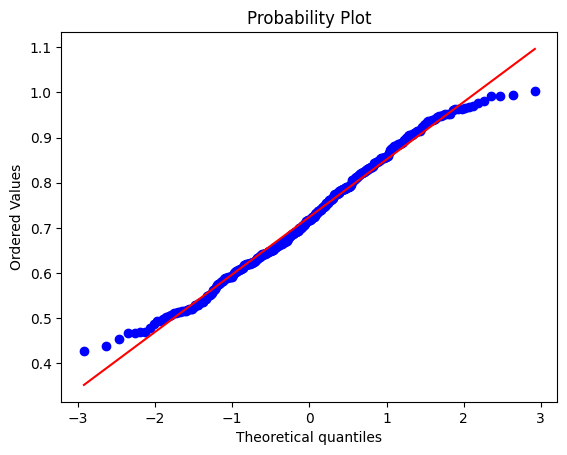

In [64]:
# error are normally distributed around the mean
import scipy.stats as stats
stats.probplot(y_hat, plot=plt)
plt.show()

In [65]:
stats.shapiro(y_hat)

ShapiroResult(statistic=np.float64(0.9880017229935417), pvalue=np.float64(0.00223375973099447))

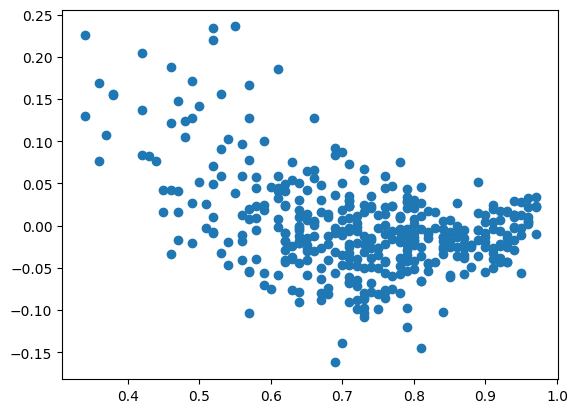

In [71]:
# plot the y-hat to check for homoscedasticity

plt.scatter(y=y_hat - y_train, x=y_train)

In [77]:
sm.stats.diagnostic.het_breuschpagan(y_hat- y_train, X_sm)
# n0 => homoscedastic, p-value is [1]

(np.float64(25.15586569245505),
 np.float64(0.0007119983594308687),
 np.float64(3.7581713300111965),
 np.float64(0.0005879783560630906))